# Census income dataset analysis

Date: 2022.10.08,

Author: © 2022 Kristupas Trakšelis 

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/)

Here we analyze US census income data from https://archive.ics.uci.edu/ml/datasets/census+income to answer the following questions:

1. [What is the correlation between education and income?](#Q1)
2. [How well can we predict if person makes over 50K a year using different classification algorithms (KNN, SVM, DT)?](#Q2)
3. [Does neural network predict better than classification algorithms (KNN, SVM, DT)?"](#Q3)


# Load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

First we read all data from adult.data dataset. We replace all question marks with NaN values and remove spaces as well.

In [3]:
df = pd.read_csv("adult.data", skipinitialspace=True, na_values="?", names=["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"])
df.head()

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


From the given data's description we can see that we do have both continuous and categorical variables

Continuous:
-   Age:
-   Fnlwgt: final weight (number of people the census believes the entry represents)
-   Education-num: numerical representation of categorical education feature
-   Capital-gain
-   Capital-loss
-   Hours-per-week

Categorical
-   Workclass
-   Education
-   Marital-status
-   Occupation
-   Relationship
-   Race
-   Sex
-   Native-country

In [4]:
continuous_features = ["Age", "Fnlwgt", "Education-num", "Capital-gain", "Capital-loss", "Hours-per-week"]
categorical_features = ["Workclass", "Education", "Marital-status", "Occupation", "Relationship", "Sex", "Race", "Income"]

# Analyze data

First of all we analize missing data, and drop rows with missing values if needed

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   Fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-num   32561 non-null  int64 
 5   Marital-status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital-gain    32561 non-null  int64 
 11  Capital-loss    32561 non-null  int64 
 12  Hours-per-week  32561 non-null  int64 
 13  Native-country  31978 non-null  object
 14  Income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


We can see that there are missing values in multiple columns like Workclass, Occupation and Native Country. So we drop rows with missing values.

In [6]:
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             30162 non-null  int64 
 1   Workclass       30162 non-null  object
 2   Fnlwgt          30162 non-null  int64 
 3   Education       30162 non-null  object
 4   Education-num   30162 non-null  int64 
 5   Marital-status  30162 non-null  object
 6   Occupation      30162 non-null  object
 7   Relationship    30162 non-null  object
 8   Race            30162 non-null  object
 9   Sex             30162 non-null  object
 10  Capital-gain    30162 non-null  int64 
 11  Capital-loss    30162 non-null  int64 
 12  Hours-per-week  30162 non-null  int64 
 13  Native-country  30162 non-null  object
 14  Income          30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Next, we will analyze continuous and categorical variables respectively.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,30162.0,38.437902,13.134665,17.0,28.00,37.0,47.0,90.0
Fnlwgt,30162.0,189793.833930,105652.971529,13769.0,117627.25,178425.0,237628.5,1484705.0
Education-num,30162.0,10.121312,2.549995,1.0,9.00,10.0,13.0,16.0
Capital-gain,30162.0,1092.007858,7406.346497,0.0,0.00,0.0,0.0,99999.0
Capital-loss,30162.0,88.372489,404.298370,0.0,0.00,0.0,0.0,4356.0
Hours-per-week,30162.0,40.931238,11.979984,1.0,40.00,40.0,45.0,99.0


We can see that columns Capital-gain and Capital-loss have huge imbalance (most of the values are 0). We can see that using histograms as well.

<AxesSubplot:xlabel='Capital-loss', ylabel='Count'>

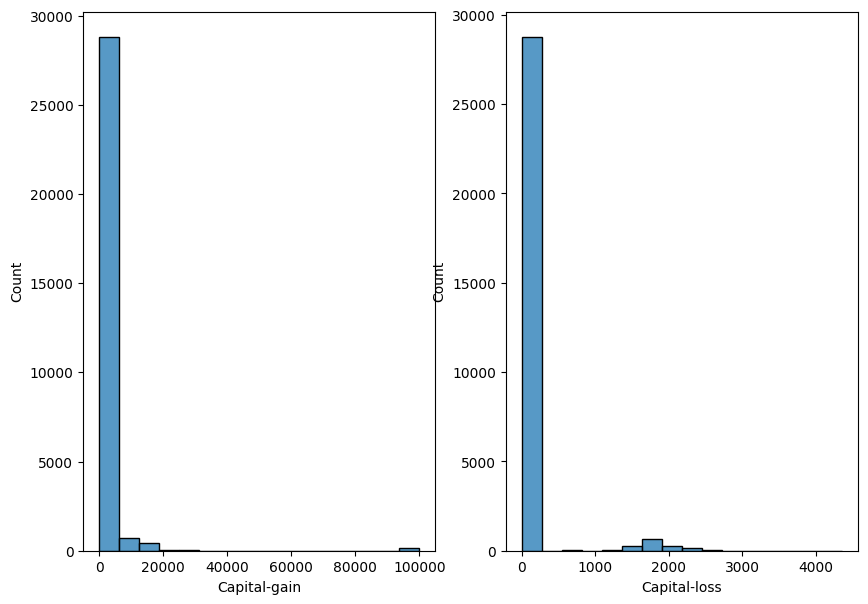

In [8]:
f, a = plt.subplots(1,2)
f.set_size_inches(10, 7)

sns.histplot(df['Capital-gain'], ax=a[0])
sns.histplot(df['Capital-loss'], ax=a[1])

Let's check age distribution as well. From the scatter plot, we can see that majority of the respondents were between 25 and 40

<AxesSubplot:xlabel='Age', ylabel='Count'>

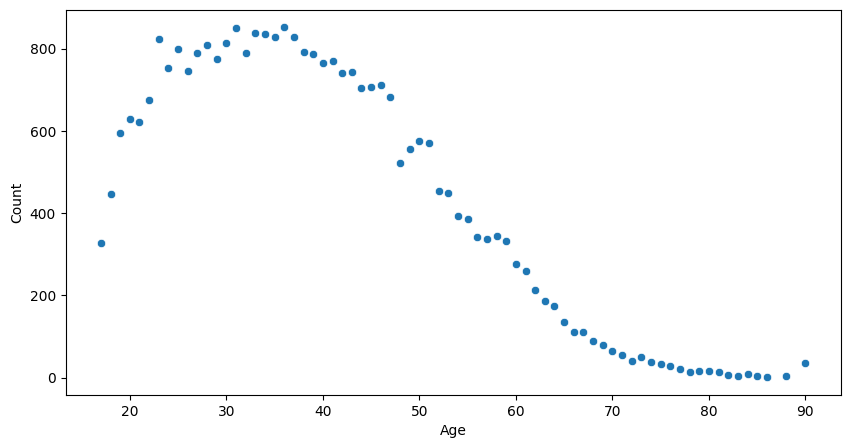

In [9]:
plt.figure(figsize=(10,5))
plt.xlabel("Age")
plt.ylabel("Count")

age_distribution = df['Age'].value_counts().sort_index()
sns.scatterplot(x=age_distribution.index.to_list(), y=age_distribution)

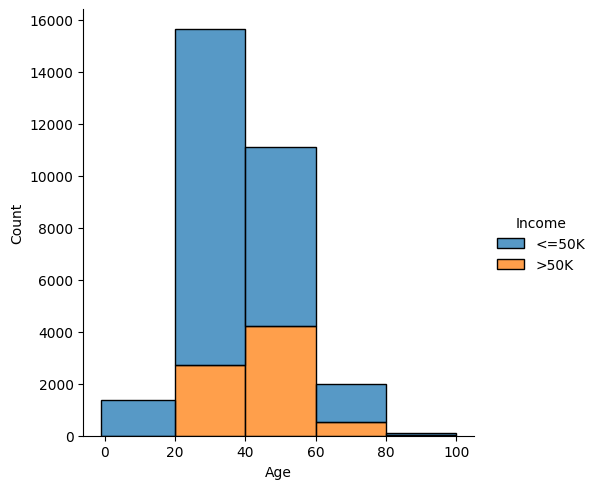

In [10]:
bins=[-1,20,40,60,80,100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']

sns.displot(df, x="Age", hue="Income", multiple="stack", bins=bins)

Looking at this distribution plot, we can see that it is highely unlikely that person makes over 50K if he is below 20. Highest percentage of people who earn more than 50K a year are in a 40-60 year group.

Analyzing categorical features, we can see some unbalancies as well.

In [11]:
df[categorical_features].astype("object").describe().T

,count,unique,top,freq
Workclass,30162,7,Private,22286
Education,30162,16,HS-grad,9840
Marital-status,30162,7,Married-civ-spouse,14065
Occupation,30162,14,Prof-specialty,4038
Relationship,30162,6,Husband,12463
Sex,30162,2,Male,20380
Race,30162,5,White,25933
Income,30162,2,<=50K,22654


<AxesSubplot:xlabel='Count', ylabel='Income'>

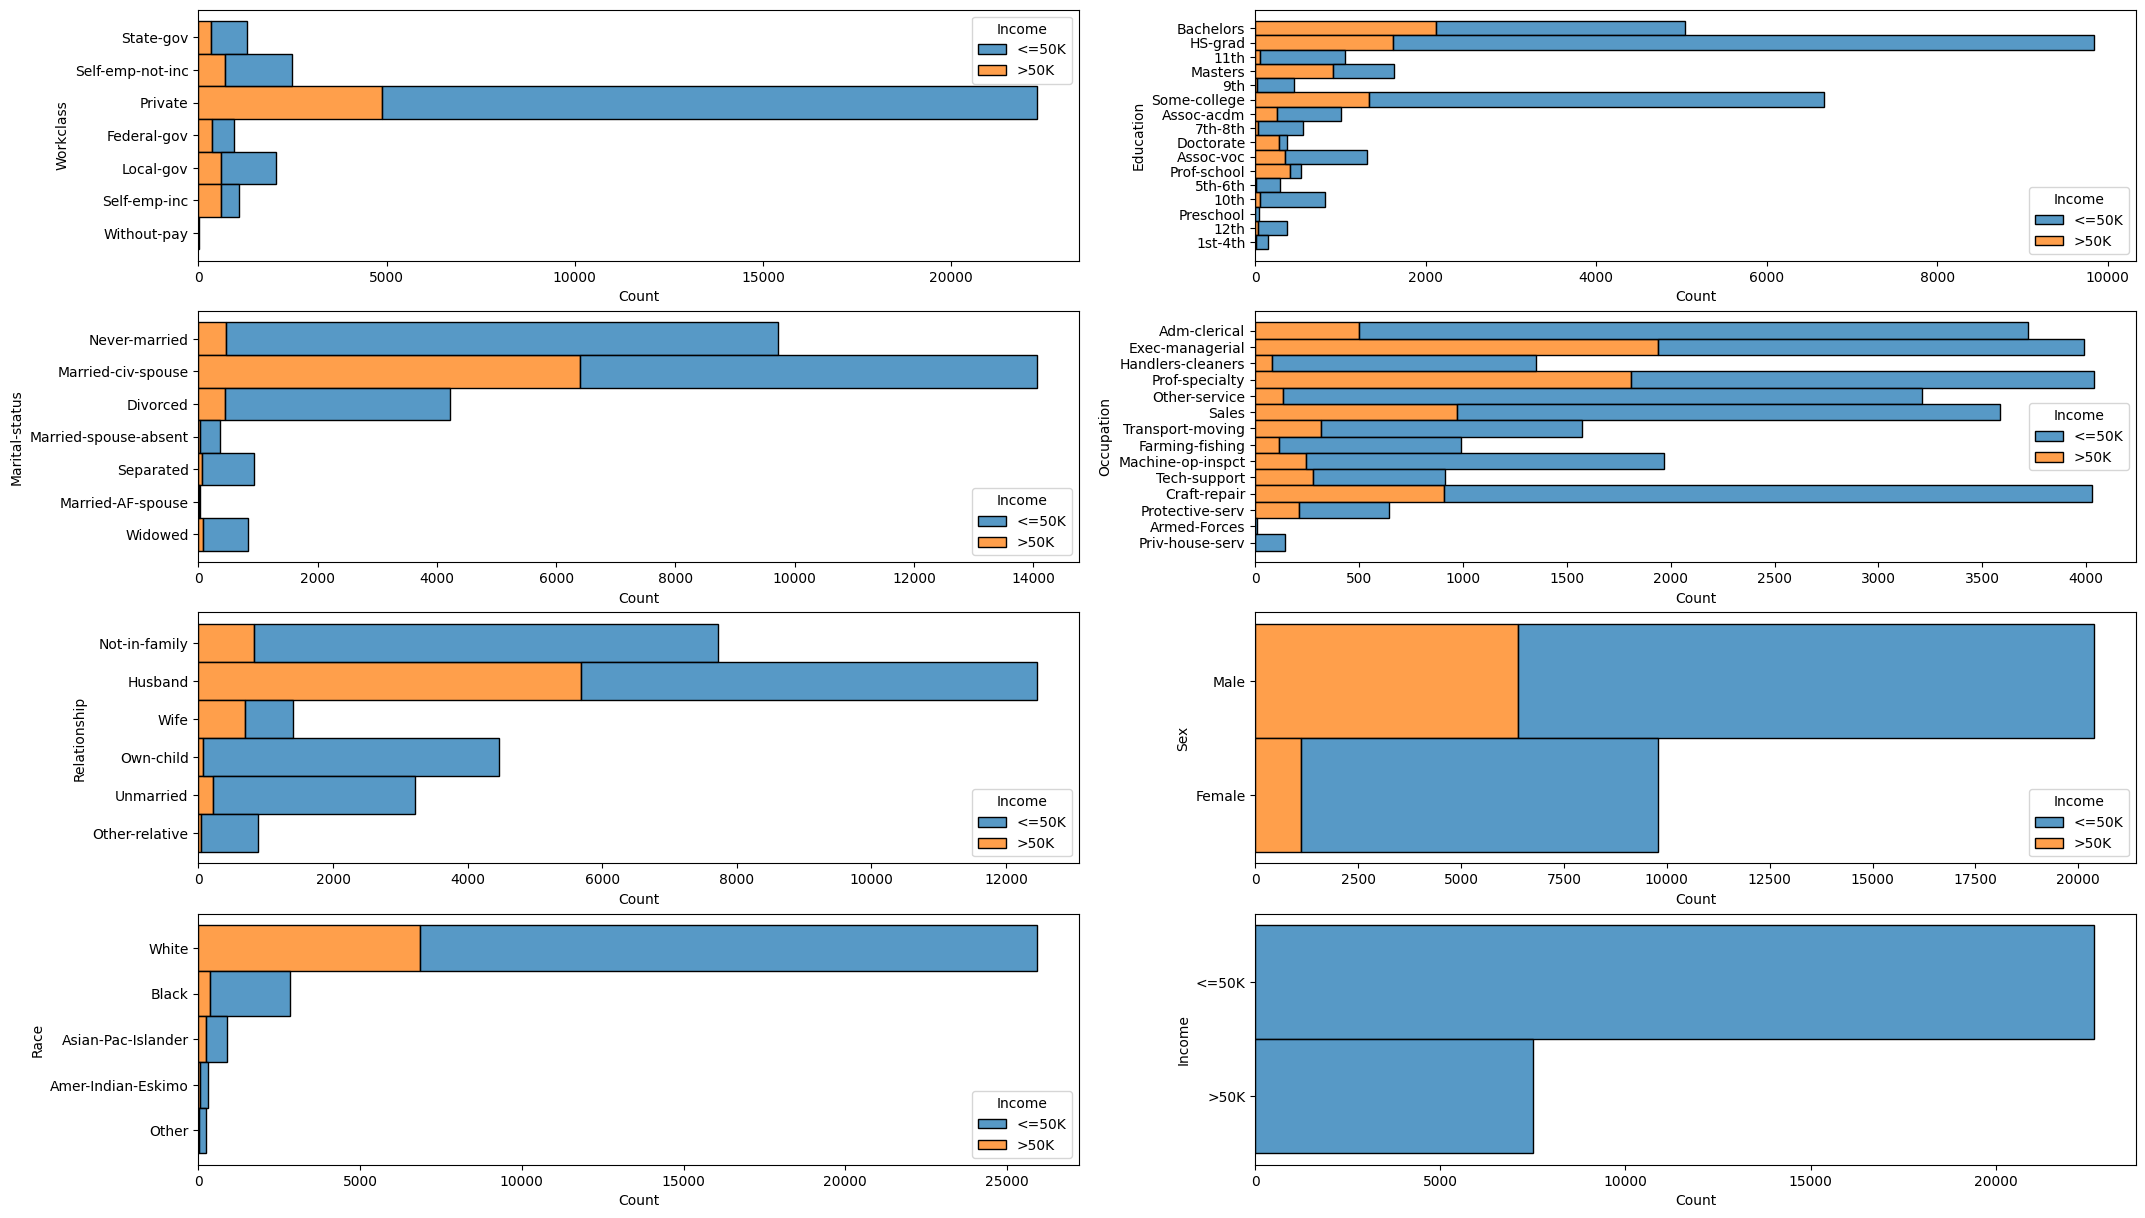

In [12]:
f, a = plt.subplots(4,2)
f.set_size_inches(25, 15)

sns.histplot(data=df, y="Workclass", hue="Income", multiple="stack", ax=a[0][0])
sns.histplot(data=df, y="Education", hue="Income", multiple="stack", ax=a[0][1])
sns.histplot(data=df, y="Marital-status", hue="Income", multiple="stack", ax=a[1][0])
sns.histplot(data=df, y="Occupation", hue="Income", multiple="stack", ax=a[1][1])
sns.histplot(data=df, y="Relationship", hue="Income", multiple="stack", ax=a[2][0])
sns.histplot(data=df, y="Sex", hue="Income", multiple="stack", ax=a[2][1])
sns.histplot(data=df, y="Race", hue="Income", multiple="stack", ax=a[3][0])
sns.histplot(data=df, y="Income", ax=a[3][1])

Majority of the respondents work in private sector. Also 2/3 are male. Biggest inbalance is in race column, where most of the people are white. Also distribution plots show that if you are female, you have are less likely to earn more than 50K. Being divorced or never-married also shows that you probably will not earn more than 50K.

# Prepare data for predictions

Get rid of the highly unbalanced features: Capital-gain and Capital-loss. Also drop Education feature since we do have numerical representation (Education-Num)

In [13]:
def drop_unneccessary_features(df):
    return df.drop(columns=["Capital-gain", "Capital-loss", "Education"])

We also need to normalize and stardartize the data, since we use distance-based prediction algorithms (KNN).

In [14]:
def standartize_data(df, column):
    df[column]=(df[column]-df[column].mean())/df[column].std()

def normalize_data(df, column):
    df[column]=(df[column]-df[column].min())/(df[column].max()-df[column].min())

Encoding for categorical data is needed aswell 

In [15]:
def one_hot_encode_single_feature(df, feature):
    encoded_feature = pd.get_dummies(df[feature], prefix=feature.lower())
    df = pd.concat((df, encoded_feature), axis=1)
    df = df.drop(columns=[feature])
    return df

def one_hot_encode_dataset_values(df, features):  
    for feature in features:
        df = one_hot_encode_single_feature(df, feature)
    return df
    
def convert_income_to_binary(df):
    return df.replace({">50K": 1, "<=50K": 0})


Create method to handle all data preparation in one place

In [16]:
def prepare_data(df):
    df = drop_unneccessary_features(df)

    normalize_data(df, "Age")
    normalize_data(df, "Fnlwgt")
    normalize_data(df, "Education-num")
    normalize_data(df, "Hours-per-week")
    
    df = one_hot_encode_dataset_values(df, ["Workclass", "Marital-status", "Occupation", "Relationship", "Sex", "Race", "Native-country"])
    df = convert_income_to_binary(df)

    return df

df_train = prepare_data(df.copy())

df_train

,Age,Fnlwgt,Education-num,Hours-per-week,Income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.301370,0.043338,0.800000,0.397959,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.047277,0.800000,0.122449,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.137244,0.533333,0.397959,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.150212,0.400000,0.397959,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.220703,0.800000,0.397959,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.165563,0.733333,0.377551,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,0.315068,0.095589,0.533333,0.397959,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,0.561644,0.093914,0.533333,0.397959,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,0.068493,0.127620,0.533333,0.193878,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


<a id="Q1"></a>
# 1. What is the correlation between education and income?

First of all, let's check education distribution plot stacked by Income. This plot shows quite a lot of information. For example, it is very unlikely that you earn more than 50K a year if you are still in a high school. You have way less chances if you don't have bachelor's as well. Also slightly more than a half of masters earn 50K. So we can expect positive correlation between education and income.

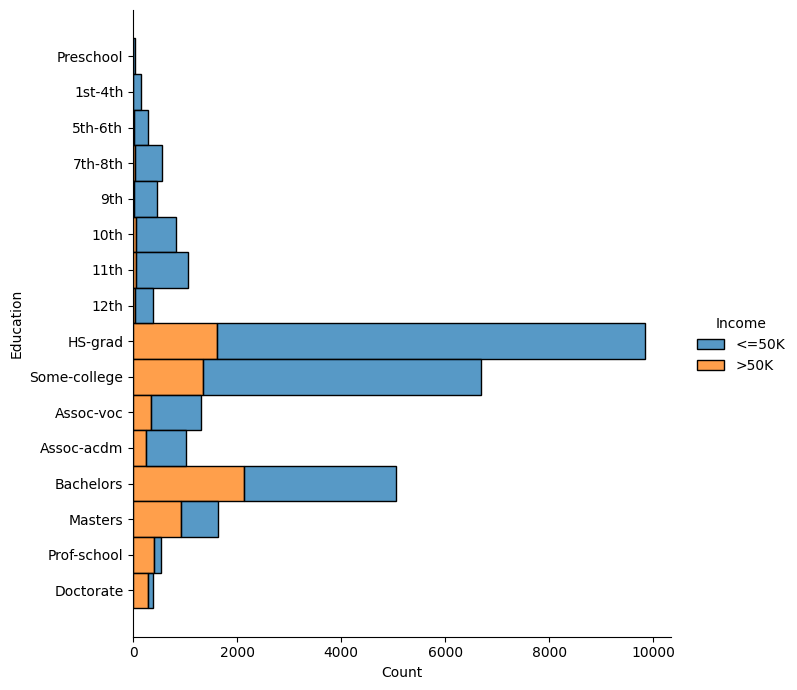

In [17]:
sns.displot(df.sort_values(by="Education-num"), y="Education", hue="Income", multiple="stack", height=7)

Calculate correalation matrix

<AxesSubplot:>

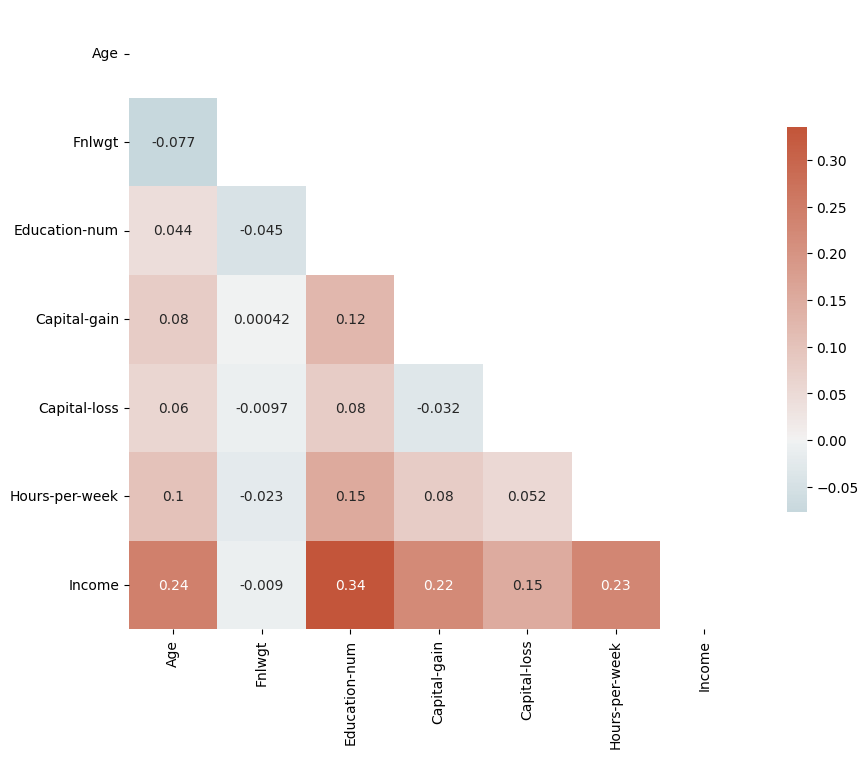

In [18]:
corr = df.replace({">50K": 1, "<=50K": 0}).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, cbar_kws={"shrink": .5}, annot=True)

Correlation matrix shows that highest positive correlation coefficient (0.34) is between Income and Education as predicted previously.

<a id="Q2"></a>
# 2. How well can we predict if person makes over 50K a year using different classification algorithms (KNN, SVM, DT)?

First of all, read test data set and prepare data like we did with train set.

In [19]:
df_test = pd.read_csv("adult.test", skiprows=1, skipinitialspace=True, na_values="?", names=["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"])

# apply Income transformation here, because for some reason dot is added at the end of the value
df_test = df_test.replace({">50K.": 1, "<=50K.": 0})

df_test = prepare_data(df_test)

df_test.head()

,Age,Fnlwgt,Education-num,Hours-per-week,Income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.109589,0.144430,0.400000,0.397959,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.287671,0.051677,0.533333,0.500000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.150685,0.219011,0.733333,0.397959,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.369863,0.099418,0.600000,0.397959,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.013699,0.060942,0.600000,0.295918,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Seperate testing, validation and training sets

In [20]:
X_train = df_train.drop(columns=["Income"]).to_numpy()
y_train = df_train["Income"].to_numpy()

X_test = df_test.drop(columns=["Income"]).to_numpy()
y_test = df_test["Income"].to_numpy()

First of all, create a function for hyperparameter tuning for each of the model. We will use 5 folds for cross validation

In [43]:
def hyperparameter_tuning(model, parameter_space, X_train, y_train):
    clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
    clf.fit(X_train, y_train)
    return clf.best_params_, clf.best_score_

Find hyperparameters for KNN

In [25]:
knn = KNeighborsClassifier()
parameter_space = {
    'n_neighbors': [8,9,10],
    'p': [1, 2]
}

best_params, best_score = hyperparameter_tuning(knn, parameter_space, X_train, y_train)

print(f"Best params for KNN: {best_params}, score: {best_score}")

knn = KNeighborsClassifier(n_neighbors=best_params["n_neighbors"], p=best_params["p"])

In [47]:
dt = DecisionTreeClassifier()
parameter_space = {
    'min_samples_leaf': np.arange(5, 15),
    'max_depth': [None, 5]
}

best_params, best_score = hyperparameter_tuning(dt, parameter_space, X_train, y_train)

print(f"Best params for Decision Tree: {best_params}, score: {best_score}")

dt = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"], max_depth=best_params["max_depth"])

Best params for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 5}, score: 0.8209669650696589


In [38]:
svc = SVC()
parameter_space = {
    'C': [1]
}

best_params, best_score = hyperparameter_tuning(svc, parameter_space, X_train, y_train)

svc = SVC(C=best_params["C"])

Check accuracies with unseen (test) data

In [39]:
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)
svc.fit(X_train, y_train)

knn_predictions = knn.predict(X_test)
dt_predictions = dt.predict(X_test)
svc_predictions = svc.predict(X_test)

Plot results

       Algorithm  Accuracy
0            KNN  0.763774
1  Decision Tree  0.776795
2            SVM  0.761931


<AxesSubplot:xlabel='Algorithm', ylabel='Accuracy'>

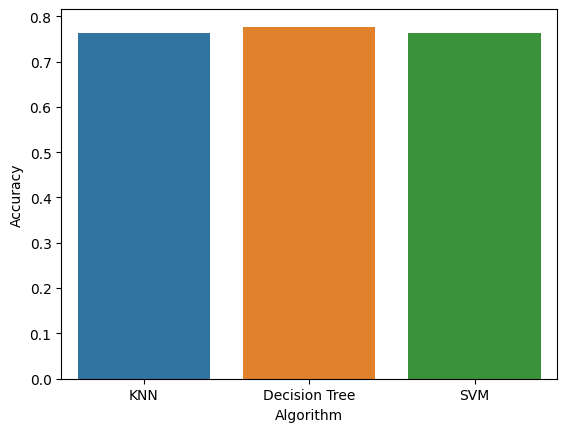

In [55]:
labels = ["KNN", "Decision Tree", "SVM"]
accuracies = [accuracy_score(y_test, knn_predictions), accuracy_score(y_test, dt_predictions), accuracy_score(y_test, svc_predictions)]

accuracy_table = pd.DataFrame({"Algorithm": labels, "Accuracy": accuracies})

print(accuracy_table)

sns.barplot(data=accuracy_table, x="Algorithm", y="Accuracy")

Even though, all three algorithms performed almost identically, best achieved accuracy was 77.67% using Decision tree with max_depth=5 and min_samples_leaf=5

<a id="Q3"></a>
# 3. Does neural network predict better than classification algorithms (KNN, SVM, DT)?